In [2]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Make Phantom

In [2]:

voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = o3d.io.read_triangle_mesh(f"{parent}/assets/breast_phantom/breast_surface.ply")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh) 

In [3]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

skin = tissue.Tissue(name='skin', c=1624, rho=1109, sigma=1.3, scale=0.00001, label=1)
fat = tissue.Tissue(name='fat', c=1440.2, rho=911, sigma=40, scale=0.0003, label=2)
ligament = tissue.Tissue(name='ligament', c=1750, rho=1142, sigma=30, scale=0.0001, label=3)
gland = tissue.Tissue(name='gland', c=1564, rho=1041, sigma=40, scale=0.0002, label=4)
tumor = tissue.Tissue(name='tumor', c=1500, rho=911, sigma=0, scale=0.0001, label=5)
muscle = tissue.Tissue(name='muscle', c=1580, rho=1090, sigma=4, scale=0.001, label=6)

kidney_file_dir = f"{parent}/assets/breast_phantom/"
kidney_tissue_list = [skin, fat, skin, gland, gland, ligament, muscle, tumor]

test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('water')

Added skin
Added fat
Added skin
Added gland
Added gland
Added ligament
Added muscle
Added tumor


In [4]:
test = test_phantom.get_complete()

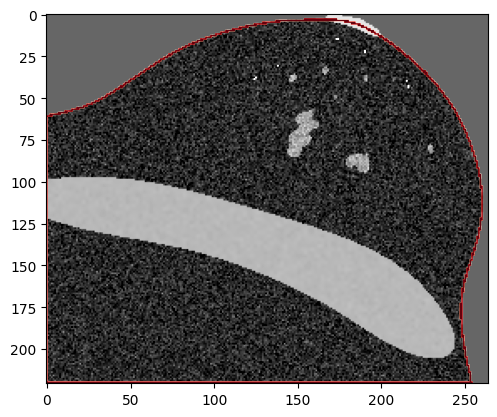

In [5]:
index = 130
plt.imshow(test[0, :, :, index], cmap='gray', vmin=1400, vmax=1650)
plt.imshow(body_mask[:,:, index] * 1000, alpha=0.5*(body_mask[:,:, index]>0)*2, cmap='Reds')

# Set up simulation

In [6]:
num_transducers = 8

# transducers = [transducer.Focused(max_frequency = 2.5e6,
#                                   elements = 128, 
#                                   width = 20e-3,
#                                   height =  20e-3,
#                                   sensor_sampling_scheme = 'not_centroid', 
#                                   sweep = np.pi/2,
#                                   ray_num = 64,
#                                   imaging_ndims = 2,
#                                   focus_azimuth = 20e-3,
#                                   focus_elevation = 40e-3) for i in range(num_transducers)]

transducers = [transducer.Focused(max_frequency = 2.5e6,
                                  elements = 128, 
                                  width = 20e-3,
                                  height =  20e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = (np.pi/2,np.pi/2),
                                  ray_num = (32,32),
                                  imaging_ndims = 3,
                                  focus_azimuth = 20e-3,
                                  focus_elevation = 40e-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [7]:
spread = np.pi * 0.23
position = [-0.063,0,0]
global_transform = geometry.Transform([-np.pi * 0.13,np.pi * -0.05,0],[0.003,0.003,-0.005], intrinsic=False)

transform1 = geometry.Transform([-spread / 3,0,0], [0,0,0])
transform2 = geometry.Transform([0,0,0], [0,0,0])
transform3 = geometry.Transform([0,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
test_transducer_set.assign_pose(0, global_transform * transform)

transform1 = geometry.Transform([spread / 3,0,0], [0,0,0])
transform2 = geometry.Transform([0,0,0], [0,0,0])
transform3 = geometry.Transform([0,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
test_transducer_set.assign_pose(1, global_transform * transform)

transform1 = geometry.Transform([-spread,0,0], [0,0,0])
transform2 = geometry.Transform([0,0,0], [0,0,0])
transform3 = geometry.Transform([0,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
test_transducer_set.assign_pose(2, global_transform * transform)

transform1 = geometry.Transform([spread,0,0], [0,0,0])
transform2 = geometry.Transform([0,0,0], [0,0,0])
transform3 = geometry.Transform([0,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
test_transducer_set.assign_pose(3, global_transform * transform)

transform1 = geometry.Transform([-spread / 2,0,0], [0,0,0])
transform2 = geometry.Transform([0,3 ** 0.5 / 2 * -spread,0], [0,0,0])
transform3 = geometry.Transform([0,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
test_transducer_set.assign_pose(4, global_transform * transform)

transform1 = geometry.Transform([-spread / 2,0,0], [0,0,0])
transform2 = geometry.Transform([0,3 ** 0.5 / 2 * spread,0], [0,0,0])
transform3 = geometry.Transform([0,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
test_transducer_set.assign_pose(5, global_transform * transform)

transform1 = geometry.Transform([spread / 2,0,0], [0,0,0])
transform2 = geometry.Transform([0,3 ** 0.5 / 2 * -spread,0], [0,0,0])
transform3 = geometry.Transform([0,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
test_transducer_set.assign_pose(6, global_transform * transform)

transform1 = geometry.Transform([spread / 2,0,0], [0,0,0])
transform2 = geometry.Transform([0,3 ** 0.5 / 2 * spread,0], [0,0,0])
transform3 = geometry.Transform([0,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
test_transducer_set.assign_pose(7, global_transform * transform)

In [8]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [9]:
# np.mean(test_sensor.sensor_coords, axis=0) / voxel_size + np.array(test.shape[1:])/2
np.mean(test_sensor.sensor_coords, axis=0)

array([-0.04022264,  0.02625165, -0.01732095])

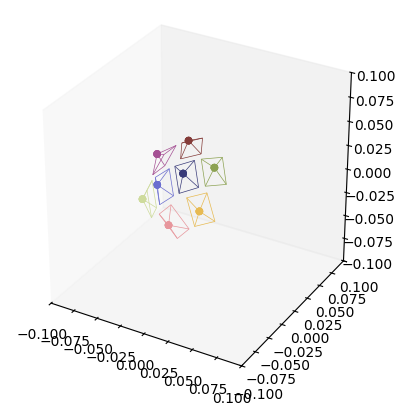

In [10]:
test_transducer_set.plot_transducer_fovs()

In [35]:
for i in range(len(test_transducer_set)):
    p = test_transducer_set[i][1]
    print(p.translation , p.rotation.as_euler('ZYX'))

[-0.04356357  0.04408974 -0.0178501 ] [-0.65523815 -0.12492945  0.09546799]
[-0.05535298  0.01650643 -0.01971736] [-0.16960058 -0.15486201  0.02640743]
[-0.02049385  0.0630041  -0.01419621] [-1.13572708 -0.0666559   0.14234134]
[-0.05317889 -0.01346807 -0.01937302] [ 0.3178183  -0.14933242 -0.04890446]
[-0.02444552  0.04153513 -0.05218204] [-0.86238365 -0.73361123  0.1470975 ]
[-0.03599038  0.04153513  0.02070933] [-0.70232369  0.50916649  0.12500562]
[-0.03860554  0.00840538 -0.05442477] [-0.05387339 -0.78264188  0.01039302]
[-0.0501504   0.00840538  0.0184666 ] [-0.04281197  0.46883892  0.00826052]


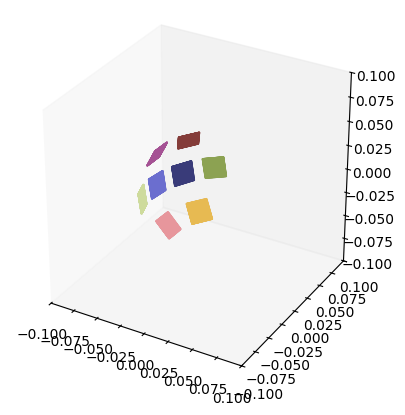

In [11]:
test_transducer_set.plot_transducer_coords()

In [12]:
simprops = simulation.SimProperties(
                grid_size   = (60e-3,15e-3,15e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (8,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [13]:
test_experiment = experiment.Experiment(
                 simulation_path = 'breast_tomography',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

In [19]:
# utils.save_mrc(test_experiment.get_sensor_mask(pad=50), 'breast_tomography_sensor_mask.mrc')

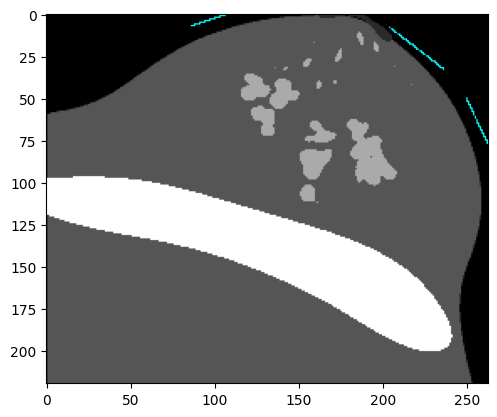

In [15]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 120])

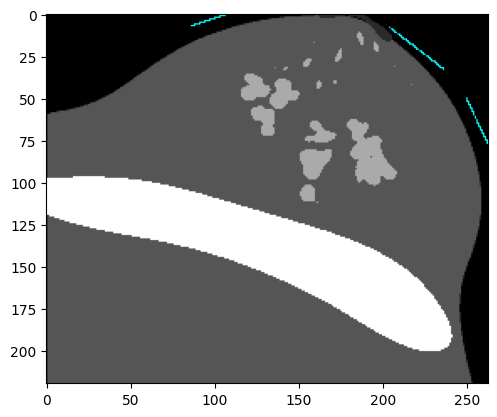

In [16]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 120])

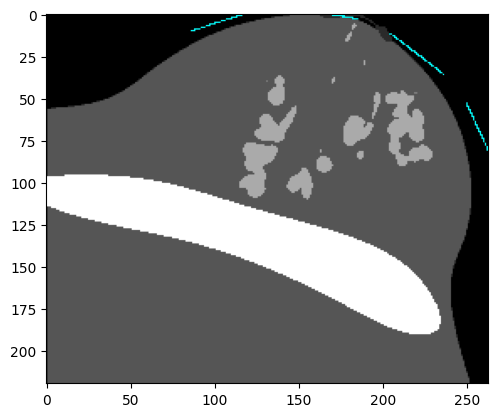

In [17]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 100])

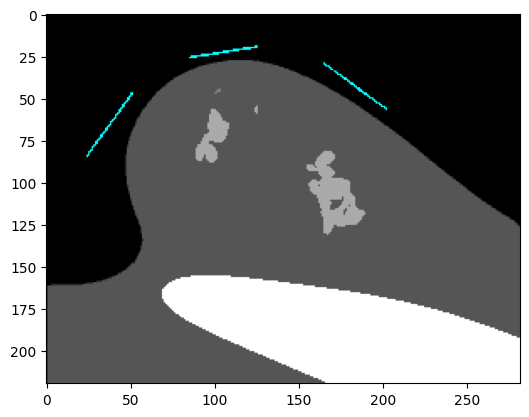

In [18]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), 220, slice(0, -1, 1)])

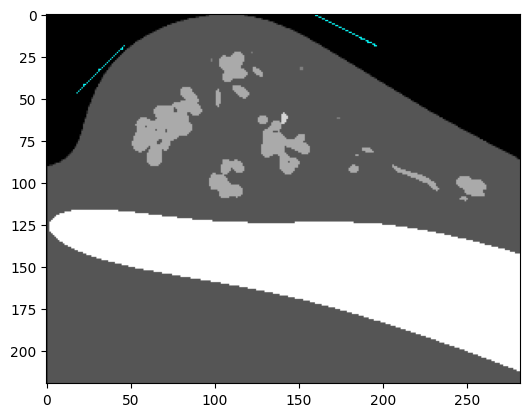

In [19]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), 150, slice(0, -1, 1)])

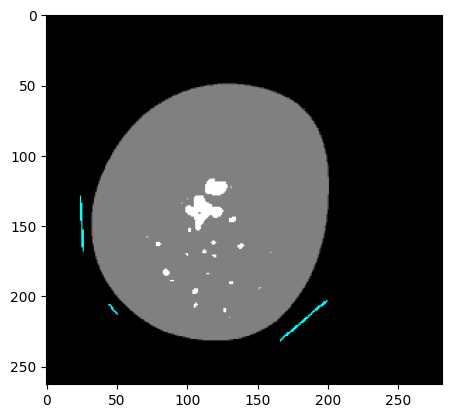

In [20]:
test_experiment.visualize_sensor_mask(index=[40, slice(0, -1, 1), slice(0, -1, 1)])

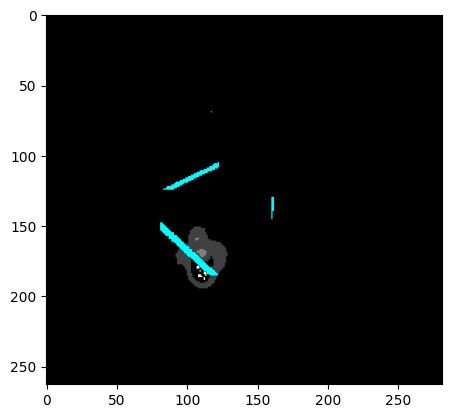

In [21]:
test_experiment.visualize_sensor_mask(index=[0, slice(0, -1, 1), slice(0, -1, 1)])

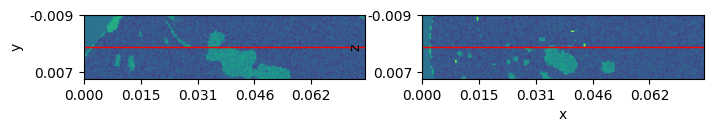

In [22]:
test_experiment.plot_ray_path(16)

# Run Simulation

In [3]:
test_experiment = experiment.Experiment.load('breast_tomography')
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 8/8 [00:35<00:00,  4.39s/it]


In [4]:
test_experiment.run(repeat=False)

Found no more simulations to run.


# Reconstruction

In [5]:
test_experiment.add_results()

In [6]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [14]:
signals = test_reconstruction.get_signals(dimensions=3, matsize=128, downsample=0.5, workers=24, tgc=10)


100%|██████████| 8192/8192 [00:55<00:00, 148.82it/s]
8it [04:05, 30.69s/it]


In [15]:
# plt.imshow(signals[0], vmax=200000)

In [16]:
# plt.imshow(signals[1], vmax=200000)

In [17]:
# plt.imshow(signals[2], vmax=200000)

In [22]:
# plt.imshow(signals[3], vmax=200000)

In [18]:
# plt.imshow(signals[4], vmax=200000)

In [19]:
# plt.imshow(signals[5], vmax=200000)

In [20]:
# plt.imshow(signals[6], vmax=200000)

In [21]:
# plt.imshow(signals[7], vmax=200000)

In [25]:
signals[0].shape

(100, 141, 141)

In [31]:
for i,signal in enumerate(signals):
    signal = np.where(np.isnan(signal), 0, signal)
    utils.save_mrc(signal, f'output/breast_tomography_signals_{i}.mrc')

In [7]:
image = test_reconstruction.get_image(dimensions=3, matsize=128, downsample=0.5, workers=24, tgc=10)
image = np.where(np.isnan(image), 0, image)
utils.save_mrc(image, 'output/breast_tomography_image.mrc')

100%|██████████| 8192/8192 [00:51<00:00, 159.06it/s]
8it [06:08, 46.12s/it]


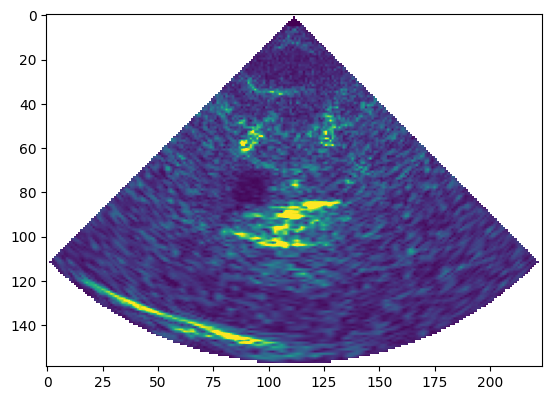

In [ ]:
# plt.imshow(signals[0], vmax=200000)
# 